# 2.0 Creating a Baseline Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import help_function as hf  # customized help functions

%matplotlib inline

In [2]:
df = pd.read_csv('data/ai4i2020.csv')

In [4]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
X = df.drop(columns='Machine failure')
y = df['Machine failure']

In [6]:
# train test split
# use stratify to enforce the proportion in the splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Create a baseline model

### 1. Build a Logistic Regression model using pipeline

In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
pipe = hf.create_pipe(clf)

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('proc_cols',
                 FunctionTransformer(func=<function col_name_cnvt at 0x000001F2C72F55E0>)),
                ('prep',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2C9691880>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2C9691850>)])),
                ('model', LogisticRegression())])

### 2. Evaluate the model performance

#### Use hard decision

In [9]:
y_pred = pipe.predict(X_test)

Recall: 0.20588235294117646
Precision: 0.7
F1: 0.3181818181818182


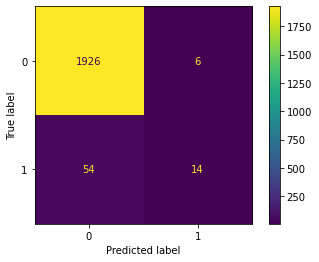

In [10]:
hf.evaluate(y_test, y_pred)

- Hard decision does not do a good job, the recall is very low.

#### Use soft decision

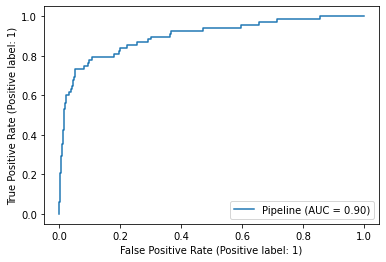

In [11]:
# Search for the best cutoff threshold
# It seems the 0.15 is a good choice
hf.RocCurveDisplay.from_estimator(pipe, X_test, y_test);

Recall: 0.6470588235294118
Precision: 0.3548387096774194
F1: 0.4583333333333333


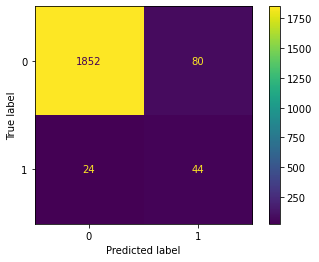

In [18]:
# Seems reasonable to set the cutoff point at 0.13
# and calculate the lables
y_probs = pipe.predict_proba(X_test)
y_hats = [1 if y_prob[1] > 0.13 else 0 for y_prob in y_probs]
hf.evaluate(y_test, y_hats)

Given the recall a more important metrics, we choise the cutoff of 0.13. The bare-bone Logistic Regression achieves Recall of **65%**, and the precision of **35%**. 

### Cross validation

In [12]:
from sklearn.model_selection import cross_validate
scoring = ['recall', 'precision']
cv = cross_validate(pipe, X_train, y_train, cv=20, scoring=scoring)
print(f"Recall: \n{cv['test_recall']}")
print(f"Precision: \n{cv['test_precision']}")

Recall: 
[0.07692308 0.15384615 0.07692308 0.         0.07692308 0.15384615
 0.07692308 0.07692308 0.07692308 0.07142857 0.28571429 0.14285714
 0.28571429 0.14285714 0.57142857 0.21428571 0.14285714 0.42857143
 0.28571429 0.21428571]
Precision: 
[0.5        1.         0.33333333 0.         0.33333333 0.66666667
 1.         1.         0.5        0.5        0.8        0.5
 1.         0.5        0.88888889 0.75       0.66666667 1.
 0.66666667 0.75      ]


- The model is clearly under-fitting. This returns a hard decision score. However in our case, cross validation is not very necessary since we have plenty of data.

### Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__penalty': ['elasticnet'],
    'model__max_iter': [500, 1000, 2000, 5000],
    'model__l1_ratio': [0, 0.5, 1],
    'model__solver': ['saga']
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=20, scoring='recall', refit=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('proc_cols',
                                        FunctionTransformer(func=<function col_name_cnvt at 0x000001F2C72F55E0>)),
                                       ('prep',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2C9691880>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001F2C9691850>)])),
                                       ('model', LogisticRegression())]),

In [20]:
grid.best_params_

{'model__l1_ratio': 1,
 'model__max_iter': 500,
 'model__penalty': 'elasticnet',
 'model__solver': 'saga'}

Recall: 0.6470588235294118
Precision: 0.352
F1: 0.45595854922279794


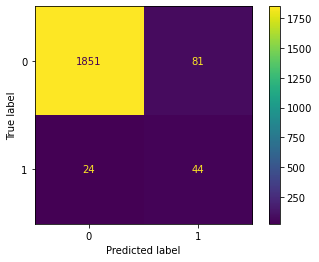

In [21]:
y_grid_probs = grid.predict_proba(X_test)
y_grid_hats = [1 if y_prob[1] > 0.13 else 0 for y_prob in y_grid_probs]
hf.evaluate(y_test, y_grid_hats)

Even with the best parameters, the model performance does not improve at all. 

So our baseline model has **Recall: ~65%**, and **Precision: ~35%**.